In [1]:
#python libraries
import os
import re
from datetime import datetime
import pytz
import copy

#other ML libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#ploting
import matplotlib.pyplot as plt
%matplotlib inline

/home/henrikhestnes/anaconda3/envs/LSTM/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Setting random seeds for reproducibility
random_seed = 420
np.random.seed(random_seed)
_ = torch.manual_seed(random_seed)

### IMPORT PBM SIMULATION

In [3]:
result_file = open("./../PBM/sim_july.csv")

#Skipping first two lines
result_file.readline()
result_file.readline()

period = result_file.readline().split()[2:10]

zone_names = result_file.readline().split()
temp_map = {key:[] for key in zone_names}
start_day, start_month, year = period[3].split('/')
start_day, start_month, year = int(start_day), int(start_month), int(year) + 2000
counter = 1
while measured_temp := result_file.readline().split():
    for i, value in enumerate(measured_temp):
        if(i == 0):
            time = value
            hour, min = time.split('h')
            hour, min = int(hour), int(min)
            day = start_day + counter//24
            if day > 31: #TODO: Brute force, FIX
                day = 1
            month = start_month + counter//(24*31)
            datetime_obj = datetime(year=year, month=month, day=day, hour=hour, minute=min, tzinfo=pytz.timezone('Etc/GMT-2'))
            temp_map[zone_names[i]].append(datetime_obj)
        else:
            temp = value
            temp_map[zone_names[i]].append(float(temp))
    counter += 1

In [4]:
sim_temp = pd.DataFrame(temp_map)
sim_temp["Time"] = pd.to_datetime(sim_temp['Time'],  utc=True).dt.tz_convert('Etc/GMT-2')
sim_temp = sim_temp.set_index('Time')

rename_map = {"Time": "timestamp",
              "Ambientdb(C)(C)": "1OutdoorEntrance_temperature",
              "gfSleepdbT(C)": "0BRoom_temperature",
              "gfLivRoomdbT(C)": "0BTLivingRoom_temperature",
              "1fEntrancedbT(C)": "1Entrance_temperature",
              "1fSleep1dbT(C)": "1GuestRoom_temperature",
              "1fSleep2dbT(C)": "1MainRoom_temperature",
              "2fLivRoomdbT(C)": "2LivingRoomCenter_temperature",
              "2fOfficedbT(C)": "2OfficeDesk_temperature"}

sim_temp = sim_temp.reset_index()[rename_map.keys()].rename(columns=rename_map).set_index("timestamp").sort_index(axis=1)
sim_temp['2Fireplace_temperature'] = sim_temp['2LivingRoomCenter_temperature']
sim_temp['2Cooking_temperature'] = sim_temp['2LivingRoomCenter_temperature']
sim_temp.head(2)

,0BRoom_temperature,0BTLivingRoom_temperature,1Entrance_temperature,1GuestRoom_temperature,1MainRoom_temperature,1OutdoorEntrance_temperature,2LivingRoomCenter_temperature,2OfficeDesk_temperature,2Fireplace_temperature,2Cooking_temperature
timestamp,,,,,,,,,,
2022-07-01 01:00:00+02:00,23.62,24.99,25.88,24.46,25.44,20.85,29.65,30.38,29.65,29.65
2022-07-01 02:00:00+02:00,23.41,24.81,25.78,24.29,25.79,20.45,28.90,29.73,28.90,28.90


### DATA CLEANING

In [5]:
#Import Disruptive & Netatmo Sensor Data

# assign variables
directory = './storedData/'
sensor_data = pd.DataFrame()
sensor_data['timestamp'] = None #in order to merge based on it 

measurement_types = ["Door", "Water", "Humidity_temperature", "Humidity_humidity", 
                     "Humidifier_humidity", "Humidifier_temperature","Temperature",
                     "Hum_temperature", "Hum_humidity"]
discrete_measurement_types = ["Door", "Water"]


# iterate over files in that directory and concat into 1 big dataframe based on timestamps
for filename in os.listdir(directory): 
    file = os.path.join(directory, filename)
    if os.path.isfile(file):    
        df = pd.read_csv(file)
        df.drop(columns=df.columns[0], inplace=True) # dropping unnamed coloumn for indexing in .cvs file

        df['timestamp'] = pd.to_datetime(df['timestamp'],  utc=True)#, format="ISO8601")#.dt.tz_convert('Europe/Rome') #set timezone correctly if not correct in local time
        df.set_index("timestamp", inplace=True)
        for measurement_name in df.columns:
            measurement_frame = df[measurement_name].to_frame()

            measurement_name_list = re.findall("([A-Z0-9][^A-Z]*)", measurement_name) # Splitting string on capital letters
            measurement_type = measurement_name_list[-1]
            if measurement_type not in measurement_types: #Temperature measurements does not have temperature in their name
                measurement_type = "Temperature"
                measurement_name_list.append(measurement_type)
            #Renaming coloumn for consistent naming
            coloumn_name = f"{''.join(measurement_name_list[:-1])}_{measurement_type.lower()}"
            measurement_frame.rename(columns={measurement_frame.columns[0]: coloumn_name}, inplace=True)
            # print(f"key: {measurement_frame.columns[0]} Value: {coloumn_name}")
            if measurement_type in discrete_measurement_types:
                #For Water Detection:
                #NOT_PRESENT == No water detected = 0
                #PRESENT     == water detected    = 1

                #For Door Sensors: - this is because sensor changes state based on if it detects objects in front of it
                #NOT_PRESENT == DOOR IS OPEN     = 0
                #PRESENT     == DOOR IS CLOSED   = 1
                
                measurement_frame.replace(['NOT_PRESENT', 'PRESENT'],[0, 1], inplace=True)
                measurement_frame = measurement_frame.resample('15T').ffill()
            else: #Contious measurement
                measurement_frame  = measurement_frame.resample('15T').mean().interpolate() #Resample to managable timestamps by taking mean of 5 minute slots and linear interpolating NaNs, i.e. 5, 10, 15, 20 minutes etc..

    
            sensor_data = pd.merge(sensor_data, measurement_frame, on='timestamp', how="outer")  

sensor_data.set_index("timestamp", inplace=True)
sensor_data.sort_index(axis=0, inplace=True) #Sorting by timestamp
sensor_data.sort_index(axis=1, inplace=True) #Sorting columns alpabetically

#Postprocesing the data in order to get rid of the NaN Values
#ffill and fillna(0/1) to populate NaN values of the proximity with ffill and then set the values before first valid value to DOOR_CLOSED/NO_WATER
sensor_data.loc[:, sensor_data.columns.str.endswith('door')] = sensor_data.loc[:, sensor_data.columns.str.endswith('door')].ffill().fillna(1)
sensor_data.loc[:, sensor_data.columns.str.endswith('water')] = sensor_data.loc[:, sensor_data.columns.str.endswith('water')].ffill().fillna(0)


# # #linearly interpolate temperature and humidity values:
sensor_data.loc[:, sensor_data.columns.str.endswith('temperature')]  = sensor_data.loc[:, sensor_data.columns.str.endswith('temperature')].interpolate().bfill().ffill()
sensor_data.loc[:, sensor_data.columns.str.endswith('humidity')]  = sensor_data.loc[:, sensor_data.columns.str.endswith('humidity')].interpolate().bfill().ffill()

### FEATURE ENGINEERING ###

In [6]:
#Add hand-designed time-of-day and day-of-year features
min_in_hour = 60
min_in_day = 24*min_in_hour
sensor_data['sin_daily'] = np.sin(2*np.pi*(sensor_data.index.minute + sensor_data.index.hour*min_in_hour)/min_in_day).values
sensor_data['cos_daily'] = np.cos(2*np.pi*(sensor_data.index.minute + sensor_data.index.hour*min_in_hour)/min_in_day).values

days_in_year = 365.2425
sensor_data['sin_yearly'] = np.sin(2*np.pi*(sensor_data.index.day_of_year)/days_in_year).values
sensor_data['cos_yearly'] = np.cos(2*np.pi*(sensor_data.index.day_of_year)/days_in_year).values

days_in_week = 7
sensor_data['sin_weekly'] = np.sin(2*np.pi*(sensor_data.index.day_of_week)/days_in_week).values
sensor_data['cos_weekly'] = np.cos(2*np.pi*(sensor_data.index.day_of_week)/days_in_week).values

### DATA PREPROCESSING

In [7]:
data = sensor_data.copy()
cols_to_drop = ['1MainBR_hum_temperature', '2BalconyEntrance_temperature', '2LRWindow_temperature',
                '2LivingRoomCenter_humidity_temperature', '2LivingRoom_humidifier_temperature'] #due to correlation
data = data.drop(cols_to_drop, axis=1)

data["0BTLivingRoom_temperature"] = (data["0BTCeiling_temperature"] + data["0BTFloor_temperature"])/2
data = data.drop("0BTFloor_temperature", axis=1).drop("0BTCeiling_temperature", axis=1).sort_index(axis=1)

data["1Entrance_temperature"] = (data["1Entrance1_temperature"] + data["1StairBottom_temperature"])/2
data = data.drop("1Entrance1_temperature", axis=1).drop("1StairBottom_temperature", axis=1).sort_index(axis=1)

drop_hum_and_water_data = True
if drop_hum_and_water_data:
    data = data.drop(data.columns[data.columns.str.endswith('humidity')], axis=1)
    data = data.drop(data.columns[data.columns.str.endswith('water')], axis=1)

In [8]:
train_df_1 = data.loc[(data.index.month < 7) & (data.index.year == 2022)].copy()
train_df_2 = data.loc[((data.index.month > 8) & (data.index.year == 2022))|(data.index.year == 2023)].copy()
train_df = pd.concat([train_df_1, train_df_2])
val_df = data.loc[(data.index.month == 8) & (data.index.year == 2022)].copy()
test_df = data.loc[(data.index.month == 7) & (data.index.year == 2022)].copy()

train_labels = train_df.loc[:, data.columns.str.endswith('temperature')].drop("1OutdoorEntrance_temperature", axis=1).sort_index(axis=1)

x_scaler = StandardScaler()
y_scaler = StandardScaler()

x_scaler.fit(train_df)
y_scaler.fit(train_labels)

train_df_1_scaled = x_scaler.transform(train_df_1)
train_df_2_scaled = x_scaler.transform(train_df_2)
train_df_1_scaled = pd.DataFrame(train_df_1_scaled, columns=train_df.columns)
train_df_2_scaled = pd.DataFrame(train_df_2_scaled, columns=train_df.columns)
val_df_scaled = x_scaler.transform(val_df)
val_df_scaled = pd.DataFrame(val_df_scaled, columns=val_df.columns)
test_df_scaled = x_scaler.transform(test_df)
test_df_scaled = pd.DataFrame(test_df_scaled, columns=test_df.columns)


print(f"Shape of train_df = {train_df.shape}, Shape of val_df = {val_df.shape}, Shape of test_df = {test_df.shape}")
print(f"Shape of labels = {train_labels.shape}")

Shape of train_df = (33214, 22), Shape of val_df = (2976, 22), Shape of test_df = (2976, 22)
Shape of labels = (33214, 10)


In [9]:
train_df.head(1)

,0BGuest_door,0BRoom_temperature,0BTLivingRoom_temperature,0B_door,1Entrance_temperature,1GuestRoom_temperature,1MainRoom_temperature,1Main_door,1OutdoorEntrance_temperature,2Cooking_temperature,...,2LivingRoomCenter_temperature,2OfficeDesk_temperature,2Office_door,2Stair_temperature,cos_daily,cos_weekly,cos_yearly,sin_daily,sin_weekly,sin_yearly
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-01-07 19:45:00+00:00,1.0,16.2,19.0875,1.0,19.65,16.25,14.9,1.0,-2.75,20.9,...,21.4,19.775,1.0,21.15,0.442289,-0.900969,0.992758,-0.896873,-0.433884,0.120129


In [10]:
import WindowGenerator
import importlib
importlib.reload(WindowGenerator)

measurements_per_day = 4*24
sequence_width = measurements_per_day #24 hours
label_width = 8 #2 hours
shift = 0

label_columns = train_labels.columns

train_windows = WindowGenerator.WindowGenerator(sequence_width, label_width, shift)
train_windows.add_data(train_df_1_scaled, label_columns)
train_windows.add_data(train_df_2_scaled, label_columns)
val_windows = WindowGenerator.WindowGenerator(sequence_width, label_width, shift)
val_windows.add_data(val_df_scaled, label_columns)
test_windows = WindowGenerator.WindowGenerator(sequence_width, label_width, shift)
test_windows.add_data(test_df_scaled, label_columns)

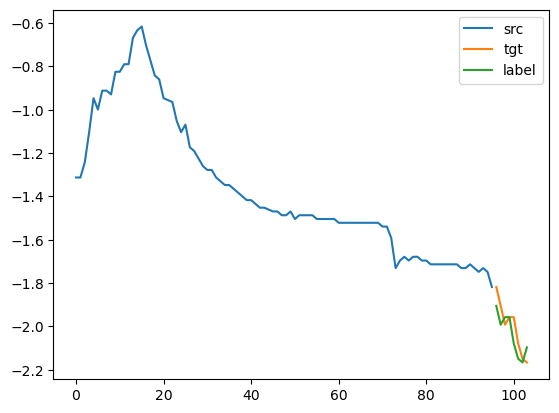

In [11]:
n = 0
src = train_windows[n][0][:,1]
tgt = train_windows[n][1][:,0]
label = train_windows[n][2][:,0]
plt.plot(range(len(src)), src, label="src")
plt.plot(range(len(src), len(src)+len(label)), tgt, label="tgt")
plt.plot(range(len(src), len(src)+len(label)), label, label="label")
plt.legend()

In [12]:
batch_size = 500
train_loader = DataLoader(train_windows, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_windows, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_windows, batch_size=len(test_windows), shuffle=False)

src, tgt, label = next(iter(train_loader))
print("Features shape:", src.shape)
print("Target shape:", tgt.shape)
print("Label shape:", label.shape)

Features shape: torch.Size([500, 96, 22])
Target shape: torch.Size([500, 8, 10])
Label shape: torch.Size([500, 8, 10])


### TRANSFORMER

In [13]:
import TransformerModel
import importlib
importlib.reload(TransformerModel)

model = TransformerModel.Transformer(num_features=train_df.shape[1], num_labels=train_labels.shape[1], input_seq_length=sequence_width, output_seq_length=label_width)
# print(model)


epochs = 10
lr = 0.001
l1_reg = 1e-9
model.train(train_loader, val_loader, epochs, lr, l1_reg)

Batch: 0, Test Loss: 1.2764016389846802
Batch: 1, Test Loss: 9.060714721679688


KeyboardInterrupt: 